In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint as pp
import gym

from lstd import LSTDQ, LSTDMu, LSPI
from simulator import Simulator
from policy import *
import sklearn.pipeline
import sklearn.preprocessing
from sklearn.kernel_approximation import RBFSampler
import seaborn as sns


In [3]:
env = gym.envs.make("MountainCar-v0")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [4]:
pp(env.observation_space.sample())
pp(env.action_space.sample())

array([-0.2121357 ,  0.03012651], dtype=float32)
1


In [5]:
def get_phi(scaler):
    # Used to converte a state to a featurizes represenation.
    # We use RBF kernels with different variances to cover different parts of the space
    phi = sklearn.pipeline.FeatureUnion([
            ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
            ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
            ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
            ("rbf4", RBFSampler(gamma=0.5, n_components=100))
            ])
    phi.fit(scaler.transform(xs))
    
    def f(s, a):
        sa = np.hstack((s, a))
        if len(sa.shape) == 1:
            sa = np.expand_dims(sa, axis=0)
        x = scaler.transform(sa)
        return phi.transform(x).T
    
    return f

def get_psi(scaler):
    # Used to converte a state to a featurizes represenation.
    # We use RBF kernels with different variances to cover different parts of the space
    psi = sklearn.pipeline.FeatureUnion([
            ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
            ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
            ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
            ("rbf4", RBFSampler(gamma=0.5, n_components=100))
            ])
    psi.fit(scaler.transform(xs))
    
    def f(s, a):
        sa = np.hstack((s, a))
        if len(sa.shape) == 1:
            sa = np.expand_dims(sa, axis=0)
        x = scaler.transform(sa)
        return psi.transform(x).T
    
    return f


# Feature Preprocessing: Normalize to zero mean and unit variance
# We use a few samples from the observation space to do this

states = np.array([env.observation_space.sample() for x in range(10000)])
actions = np.array([env.action_space.sample() for x in range(10000)]).reshape(10000, 1)
xs = np.hstack((states, actions))

print(xs.shape)
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(xs)

def simple_phi(s, a):
    # identity
    return np.expand_dims(np.hstack((s, a)), axis=1)

#phi = get_phi(scaler)
phi = simple_phi
# for now, let's keep psi == phi
psi = phi


(10000, 3)


In [6]:
a = phi(env.observation_space.sample(), env.action_space.sample())
print("")
b = psi(env.observation_space.sample(), env.action_space.sample())

pp(a[0, :10])
pp(a.shape)
print("")
pp(b.shape)


array([-0.62383181])
(3, 1)

(3, 1)


In [7]:
env.action_space.sample()

1

# make some policies

In [8]:
# pi_expert


# pi_explore
pi1 = RandomPolicy2(choices=[0]) # left
pi2 = RandomPolicy2(choices=[2]) # right
pi3 = RandomPolicy2(choices=[0, 2]) # left, right

class ManualPolicy():
    def choose_action(self, s):
        pos, v = s
        return 0 if v <=0 else 2
pi4 = ManualPolicy()
# pi_evaluate
pi5 = RandomPolicy2(choices=[0, 1, 2]) # left, right




## collect data from behavior policy

In [9]:
state_dim = env.observation_space.shape[0]
# discrete action
action_dim = 1

pp(state_dim)
pp(action_dim)

n_action = env.action_space.n

sim = Simulator(env, state_dim=state_dim, action_dim=action_dim)

2
1


In [130]:
trajs1 = sim.simulate(pi1, n_trial=1, n_episode=100)
trajs2 = sim.simulate(pi2, n_trial=1, n_episode=100)
trajs3 = sim.simulate(pi3, n_trial=1, n_episode=100)
trajs4 = sim.simulate(pi4, n_trial=1, n_episode=100)
trajs = trajs1+trajs2+trajs3+trajs4

## trajectories under behavior policy (=D)

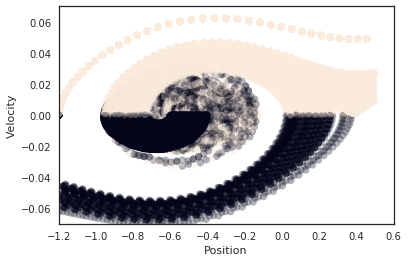

In [131]:
states = []
actions = []
for t in trajs:
    for (s, a, r, s_next, done) in t:
        states.append(s)
        actions.append(a)

states = np.array(states)
sns.set(style='white', palette='Blues')
ax = plt.gca()
sc = ax.scatter(states[:,0], states[:,1], c=actions, alpha=0.3)
ax.axis([-1.2,0.6,-0.07,0.07])
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
#plt.colorbar(sc)
plt.show()

## trajectories under evaluation policy

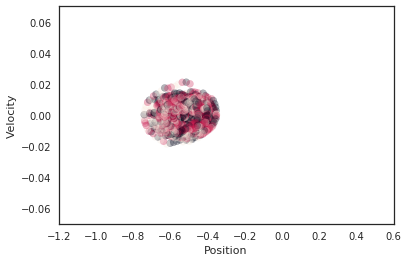

In [132]:
trajs5 = sim.simulate(pi5, n_trial=1, n_episode=10)
states = []
actions = []
for t in trajs5:
    for (s, a, r, s_next, done) in t:
        states.append(s)
        actions.append(a)

states = np.array(states)
sns.set(style='white', palette='Blues')
ax = plt.gca()
sc = ax.scatter(states[:,0], states[:,1], c=actions, alpha=0.3)
ax.axis([-1.2,0.6,-0.07,0.07])
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
#plt.colorbar(sc)
plt.show()

## Monte Carlo Mu estimation

In [133]:
import itertools
def estimate_mu_mc(env, pi, phi, gamma, n_episode):
    mus = []
    ss_init = []
    for epi_i in range(n_episode):
        
        # this is not fixed
        s = env.reset()
        ss_init.append(s)
        mu = 0.0
        for t in itertools.count():
            a = pi.choose_action(s)
            s_next, r, done, _ = env.step(a)
            # todo figure out whether it's phi(s,a) or phi(s)
            mu += gamma ** t * phi(s, a)
            s = s_next
            if done:
                break
        mus.append(mu)
    return mus, ss_init

In [134]:
mus_mc, ss_init = estimate_mu_mc(env, pi5, phi, gamma, 100)
mus_mc = np.array(mus_mc).squeeze()

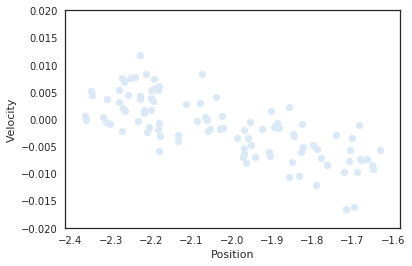

In [146]:
ax = plt.gca()
#ax.plot(mus_mc[:, 0])
ax.scatter(mus_mc[:, 0], mus_mc[:, 1])
ax.set_ylim(-0.02, 0.02)
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
#plt.colorbar(sc)
plt.show()

## LSTD-mu estimation

In [136]:
# depends on basis function
p = 3
q = 3
gamma= 0.75
lm = LSTDMu(p=p, q=q, phi=phi, psi=psi, gamma=gamma, eps=0.1)
lm.fit(D=trajs5, pi=pi5)


array([[  4.00293696e+00,   1.33196225e-03,  -5.67096948e+00],
       [  1.99806015e+00,   6.70185190e-01,  -4.62378961e+00],
       [  3.67882318e-03,   4.96983868e-04,   1.02317150e+00]])

In [137]:
s = [-0.3, 0.1]
a = 0
mu_lstd = lm.predict(s, a)
pp(mu_lstd)

array([[-1.00107507],
       [ 0.06661893],
       [ 1.23891188]])


In [147]:
#pp(np.mean(mus, axis=0))
mus_lstd = []
for s0 in ss_init:
    mu = lm.predict(s0, pi5.choose_action(s0))
    mus_lstd.append(mu)
mus_lstd = np.array(mus_lstd).squeeze()

In [148]:
mus_lstd[:].shape

(100, 3)

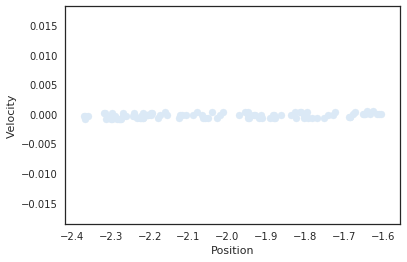

In [149]:
ax = plt.gca()
ax.scatter(mus_lstd[:, 0], mus_lstd[:, 1])
#ax.axis([-1.2,0.6,-0.07,0.07])
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
#plt.colorbar(sc)
plt.show()